In [10]:
IDENTIFIER = "beethoven-op67"
NUM = 3

import matplotlib.pyplot as plt
import json
import networkx as nx
import pandas as pd
import numpy as np
from dwave.system import DWaveSampler, FixedEmbeddingComposite
from dwave.samplers import SteepestDescentSolver, SimulatedAnnealingSampler, TabuSampler
import dwave.inspector

from plots import plotHistogram, plotCSV, plotSampleGraph
from qubo import createBQM
from samples import totalEntropy, firstValid, overlaps, duplicates

picklePath = f"../Pickles/{IDENTIFIER}/{IDENTIFIER}_"
numPath = f"../Pickles/{IDENTIFIER}/{NUM}/{IDENTIFIER}_{NUM}_"
dataPath = f"../Data/{IDENTIFIER}/{NUM}/{IDENTIFIER}_{NUM}_"

phrases = pd.read_csv(picklePath + "phrases.csv", index_col=[0,1])
G = nx.read_graphml(picklePath + "graph.graphml")
instruments = json.load(open(numPath + "instruments.json"))
embedding = json.load(open(numPath + "embedding.json", "r"))

# Re-record samples with lower chain strength and anneal time
# Ignore low energy samples that don't fulfil constraints

In [ ]:
reads = 1000

qa = qa.sample(bqm, num_reads=reads, label=f"Haydn_{reads}").to_pandas_dataframe(True)
sd = SteepestDescentSolver().sample(bqm, num_reads=reads).to_pandas_dataframe(True)
sa = SimulatedAnnealingSampler().sample(bqm, num_reads=reads).to_pandas_dataframe(True)
ta = TabuSampler().sample(bqm, num_reads=reads).to_pandas_dataframe(True)

#random = RandomSampler().sample(bqm, num_reads=1000).to_pandas_dataframe(True)

plt.subplot(4, 1, 1)
plt.title("Annealing")
plotHistogram(qa)
plt.subplot(4, 1, 2)
plt.title("Steepest descent")
plotHistogram(sd)
plt.subplot(4, 1, 3)
plt.title("Simulated annealing")
plotHistogram(sa)
plt.subplot(4, 1, 4)
plt.title("Tabu")
plotHistogram(ta)

plt.show()

In [12]:
cs = 30
at = 200

def recordEnergyReads(readRange, bqm, sampler, filepath: str, header: bool = False, quantum: bool = False):
    
    file = pd.DataFrame()
    for r in readRange:

        if quantum:
            sampleset = sampler.sample(bqm, num_reads=r, chain_strength=cs, annealing_time=at,label=f"{IDENTIFIER}_{r}_{cs}_{at}")
        else:
            sampleset = sampler.sample(bqm, num_reads=r)
        
        sample = sampleset.first

        if quantum:
            new_row = pd.DataFrame({
                "Total reads": [r],
                "Time": [sampleset.info["timing"]["qpu_sampling_time"]],
                "Chain strength": [cs],
                "Chain break fraction": [sample.chain_break_fraction],
                "Lowest energy": [bqm.energy(sample.sample)],
                "Total entropy": [totalEntropy(sample.sample, G)],
                "Overlaps": [overlaps(sample.sample, G)],
                "Duplicates": [duplicates(sample.sample, G)]
                })
        else:
            new_row = pd.DataFrame({
                "Total reads": [r],
                "Lowest energy": [bqm.energy(sample.sample)],
                "Total entropy": [totalEntropy(sample.sample, G)],
                "Time": [sampleset.info["timing"]["sampling_ns"]/1000],
                })
    
        print(f"{r} reads recorded!")
        file = pd.concat([file, new_row])

    file.to_csv(filepath, index=False, mode="a", header=header)

bqm = createBQM(G, phrases, instruments, 6, 12, 1) # CHANGE
qa = FixedEmbeddingComposite(DWaveSampler(), embedding)
sa = SimulatedAnnealingSampler()
sd = SteepestDescentSolver()

# 200 to 2000 repeated
readRange = np.arange(200,2200,200)

#recordEnergyReads(readRange, bqm, qa, dataPath+"qa-reads.csv", quantum=True, header=False)
recordEnergyReads(readRange, bqm, sa, dataPath+"sa-reads.csv", quantum=False, header=False)
recordEnergyReads(readRange, bqm, sd, dataPath+"sd-reads.csv", quantum=False, header=False)

200 reads recorded!
400 reads recorded!
600 reads recorded!
800 reads recorded!
1000 reads recorded!
1200 reads recorded!
1400 reads recorded!
1600 reads recorded!
1800 reads recorded!
2000 reads recorded!
200 reads recorded!
400 reads recorded!
600 reads recorded!
800 reads recorded!
1000 reads recorded!
1200 reads recorded!
1400 reads recorded!
1600 reads recorded!
1800 reads recorded!
2000 reads recorded!


In [ ]:
sampleset = qa.sample(bqm, num_reads=1)
print(sampleset.info["timing"])
#plotSampleGraph(sampleset.first.sample, G, instruments)
#plotArrangement(sampleset.first.sample, phrases, instruments)

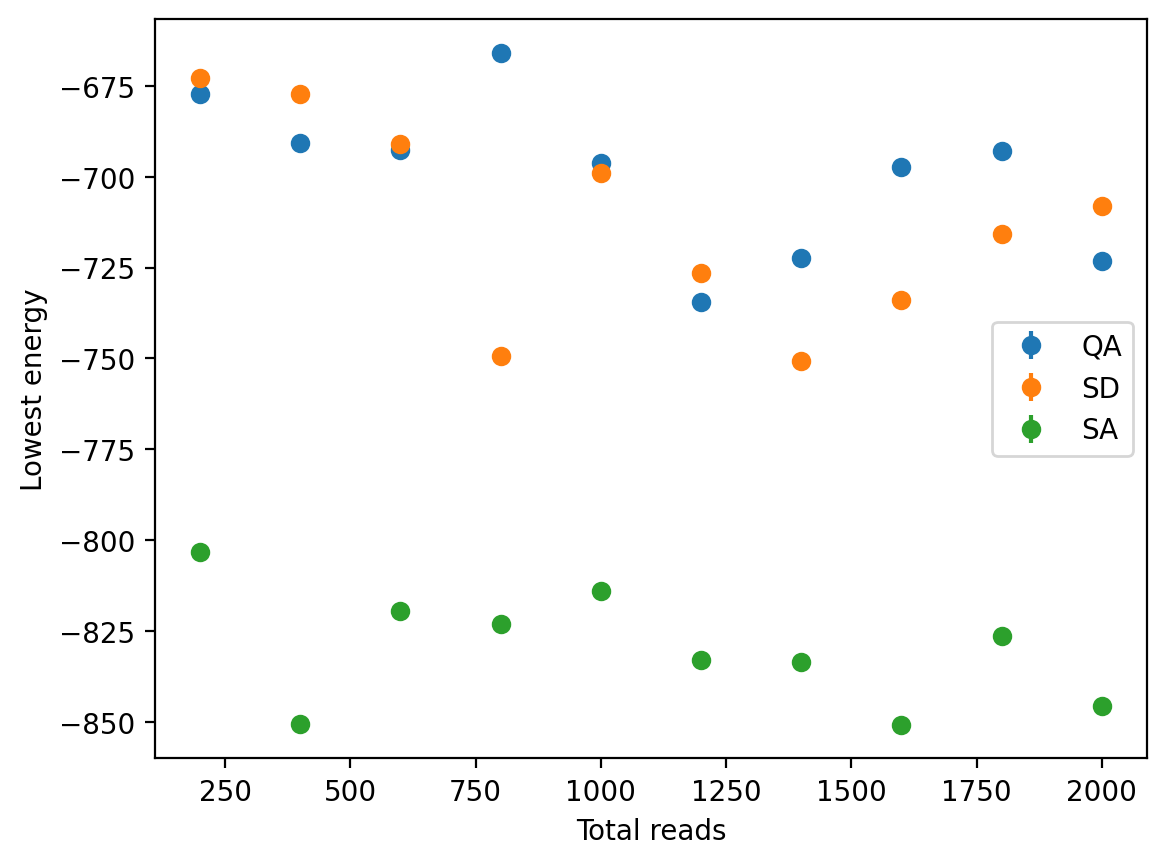

In [3]:
def compareAll(yaxis: str):

    plotCSV(path+"qa-reads.csv", "Total reads", yaxis, "QA")
    plotCSV(path+"sd-reads.csv", "Total reads", yaxis, "SD")
    plotCSV(path+"sa-reads.csv", "Total reads", yaxis, "SA")
    #plotCSV(path+"ta-reads.csv", "Total reads", yaxis, "TA")
    plt.legend()
    #plt.ylim(0,1e6)
    plt.show()

# Tabu has lowest energy and higher entropy and score looks a lot better
# Maybe annealer chain strength should change?
compareAll("Lowest energy")
#plotSampleGraph(sampleset.first.sample, G, instruments)
#dwave.inspector.show(sampleset)

# DONE: Check if chain strength can optimise solution further

In [ ]:
# Both correctly maximise total node weight (-212.02...)
# Both maximise node and edge weight (-1891.18...)
# Both maximise node and edge weight with adjacent vertices different colours (QA does better than SD but not SA) (~-247)
# There was a bug in edge weighting, didn't import `iter` module :(

print(results.sort_values("energy").head()[["energy", "chain_break_fraction", "num_occurrences"]])
print(sd.sort_values("energy").head()[["energy", "num_steps"]])
print(sa.sort_values("energy").head()[["energy", "num_occurrences"]])